# Inference: Haario-Bardenet adaptive covariance MCMC

This example shows you how to perform Bayesian inference on a time series, using a variant of [Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_bardenet_ac_mcmc.html) detailed in supplementary materials of [1].

[1] Uncertainty and variability in models of the cardiac action potential:
    Can we build trustworthy models?
    Johnstone, Chang, Bardenet, de Boer, Gavaghan, Pathmanathan, Clayton,
    Mirams (2015) Journal of Molecular and Cellular Cardiology

It follows on from the [first sampling example](./first-example.ipynb).

Running...
Done!


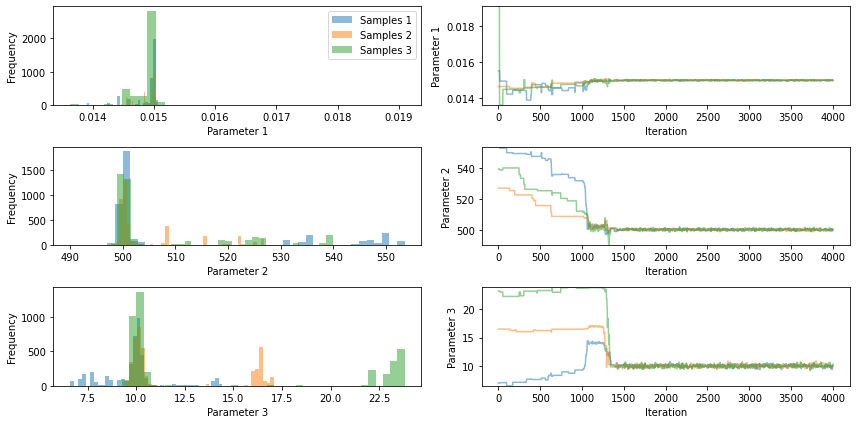

In [4]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import time

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*10]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_pdf=log_posterior, chains=3, method=pints.HaarioBardenetACMC,
                            x0=log_prior)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
time = end - start

pints.plot.trace(chains)
plt.show()

Look at pairwise samples post-convergence.

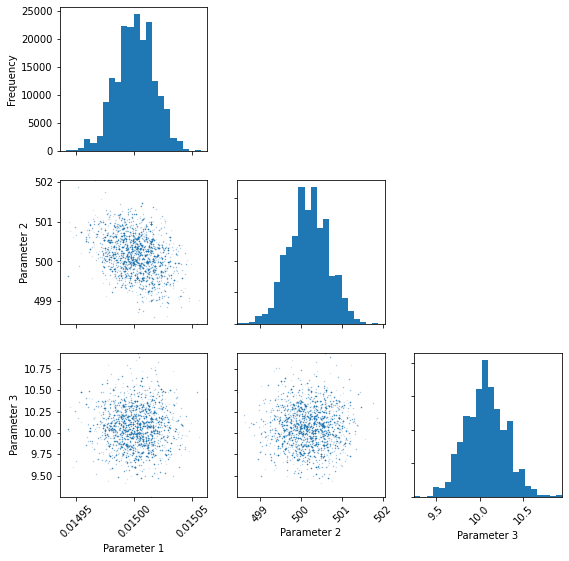

In [5]:
# discard warmup
chains = chains[:, 2000:, :]

pints.plot.pairwise(np.vstack(chains), kde=False)

# Show graphs
plt.show()

Use a results object to tabulate parameter-specific results.

In [6]:
results = pints.MCMCSummary(chains=chains, time=time, parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.02    0.00    0.01    0.01    0.02    0.02    0.02     1.01    435.71  86.48
k        500.18  0.48    499.24  499.85  500.18  500.52  501.10   1.00    470.04  93.29
sigma    10.07   0.23    9.63    9.91    10.07   10.21   10.52    1.00    486.21  96.50
